<a href="https://colab.research.google.com/github/dong-uk-kim97/Aiffel_project/blob/main/Going_Deeper_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 버전 확인하기

In [1]:
# ! pip uninstall -y tensorflow
# ! pip uninstall -y numpy
# ! pip uninstall -y cv2
# ! pip uninstall -y Pillow
# ! pip install tensorflow==2.6.0
# ! pip install numpy==1.21.4
# ! pip install cv2==4.5.3
# ! pip install Pillow==8.3.2
# ! pip install keras==2.6.0
# ! pip uninstall -y tensorflow_datasets
# ! pip install tensorflow_datasets==4.4.0

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
import PIL
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.6.0
8.3.2


# CAM 구현하기

데이터셋 구축

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='content/Drive/Mydrive/CAM'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to content/Drive/Mydrive/CAM/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


train 이미지 확인

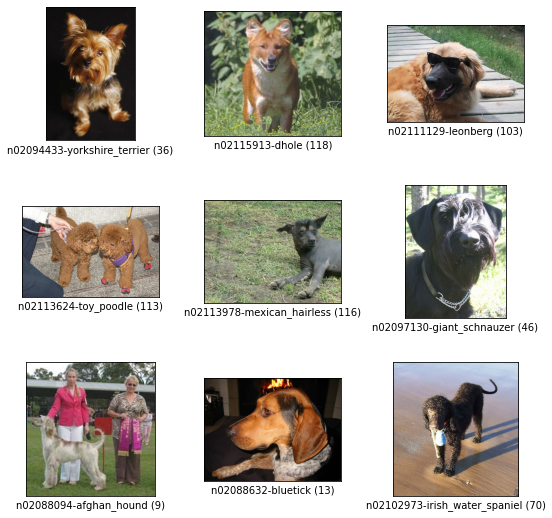

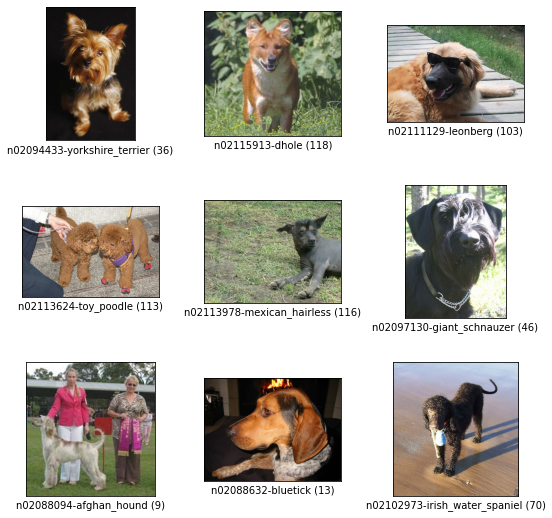

In [4]:
tfds.show_examples(ds_train, ds_info)

test 이미지 확인

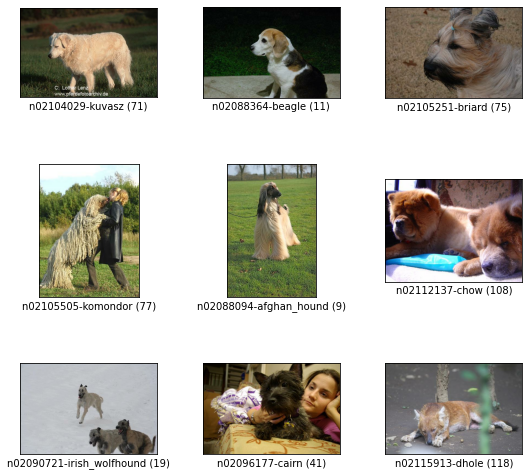

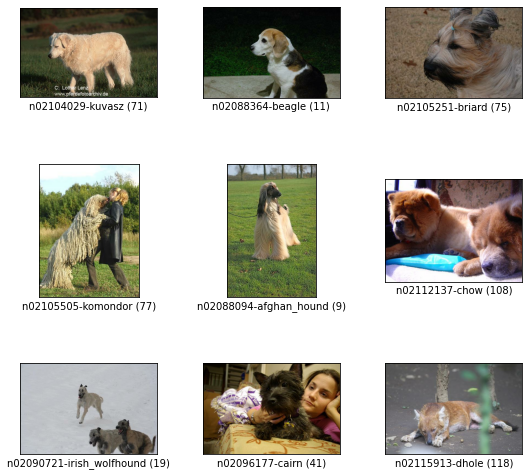

In [5]:
tfds.show_examples(ds_test, ds_info)

ds_info feature 확인

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [7]:
num_classes=ds_info.features['label'].num_classes
base_model=keras.applications.resnet50.ResNet50(
    include_top=False, # fully-connected layer 제거
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg', # global average pooling 사용
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

normalize_and_resize_img함수 와 apply_normalize_on_dataset 함수 정의

In [9]:
def normalize_and_resize_img(input):
    # Normalizes and images: 'unit8' -> 'float32'
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image,tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
      ds = ds.repeat()
      ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

전처리와 배치처리 적용

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)
for input in ds_train_norm.take(1):
  image, label = input
  print(image.shape)
  print(label.shape)

(16, 224, 224, 3)
(16,)


CAM 모델 학습하기

In [11]:
from keras.callbacks import EarlyStopping

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data = ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)
model_path = '/content/drive/MyDrive/CAM/cam_model.h5'
cam_model.save(model_path)

Epoch 1/20
750/750 [==============================] - 180s 217ms/step - loss: 2.2412 - accuracy: 0.4378 - val_loss: 3.7169 - val_accuracy: 0.1608
Epoch 2/20
750/750 [==============================] - 162s 215ms/step - loss: 0.6953 - accuracy: 0.8068 - val_loss: 1.2099 - val_accuracy: 0.6543
Epoch 3/20
750/750 [==============================] - 162s 216ms/step - loss: 0.2160 - accuracy: 0.9566 - val_loss: 0.9591 - val_accuracy: 0.7198
Epoch 4/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0592 - accuracy: 0.9947 - val_loss: 0.9106 - val_accuracy: 0.7300
Epoch 5/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0274 - accuracy: 0.9992 - val_loss: 0.9908 - val_accuracy: 0.7187
Epoch 6/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0311 - accuracy: 0.9987 - val_loss: 0.9633 - val_accuracy: 0.7283
Epoch 7/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0205 - accuracy: 0.9990 - val_loss: 0.9682 -

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [12]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


116


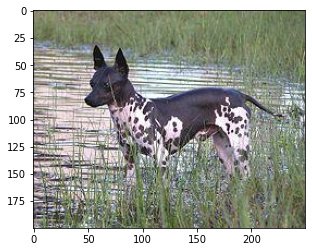

In [13]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [14]:
cam_model_path ='/content/drive/MyDrive/CAM/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

## 3.1 CAM 구현하기

In [15]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

## 3.2 CAM 이미지 생성

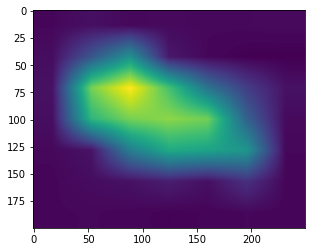

In [16]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

## 3.3 CAM 이미지 원본 이미지와 합성

In [17]:
def visualize_cam_on_image(src1, src2, alpha=0.3):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

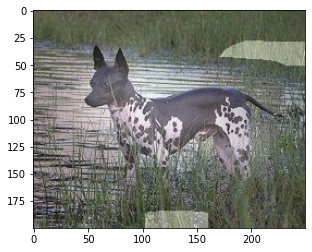

In [18]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

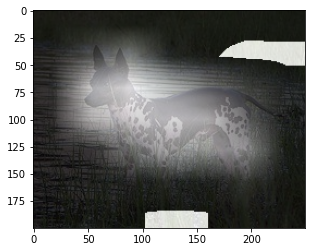

In [19]:
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, alpha=0.8)
plt.imshow(blended_image)
plt.show()

# 4. Grad-CAM

## 4.1 Grad-CAM 구현하기

In [20]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

## 4.2 Grad-CAM 이미지 생성

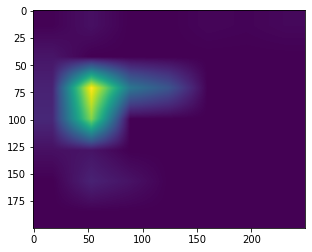

In [21]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## 4.3 Grad-CAM 이미지 원본 이미지와 합성

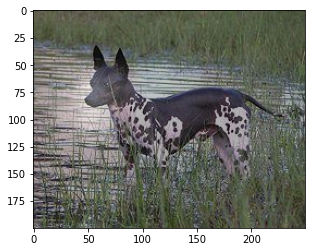

In [22]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)
plt.show()

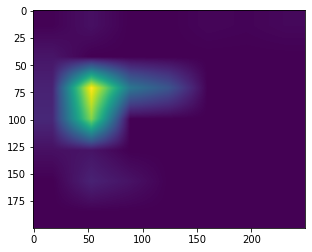

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

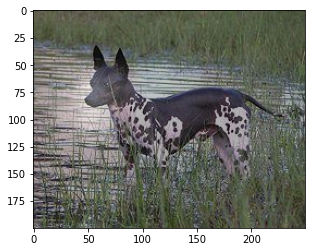

In [24]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)
plt.show()

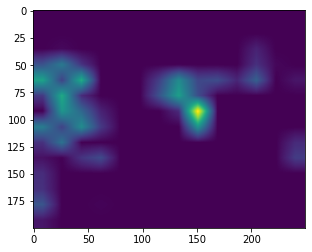

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

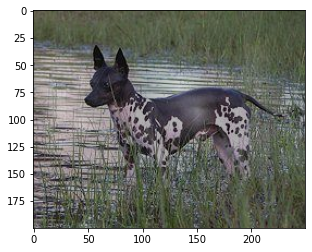

In [26]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)
plt.show()

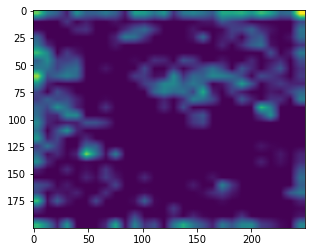

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

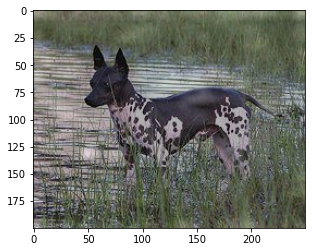

In [28]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)
plt.show()

# 5. 바운딩 박스 구하기

In [29]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

## 5.1 바운딩 박스 얻기

In [30]:
rect = get_bbox(cam_image)
rect

array([[  3, 140],
       [ 28,   4],
       [244,  43],
       [219, 179]])

## 5.2 바운딩 박스 시각화

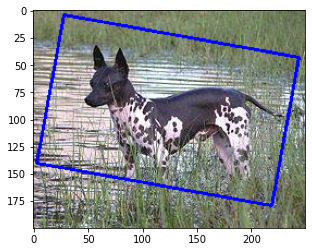

In [31]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

# 6. IoU 구하기

In [32]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [33]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.02, 0.012, 0.895, 0.976]

In [34]:
item['objects']['bbox']

array([[0.165, 0.192, 0.8  , 0.924]], dtype=float32)

In [35]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [36]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5510610522217629

# 7. 결과 비교하기

## 7.1 CAM, Grad-CAM 결과 비교

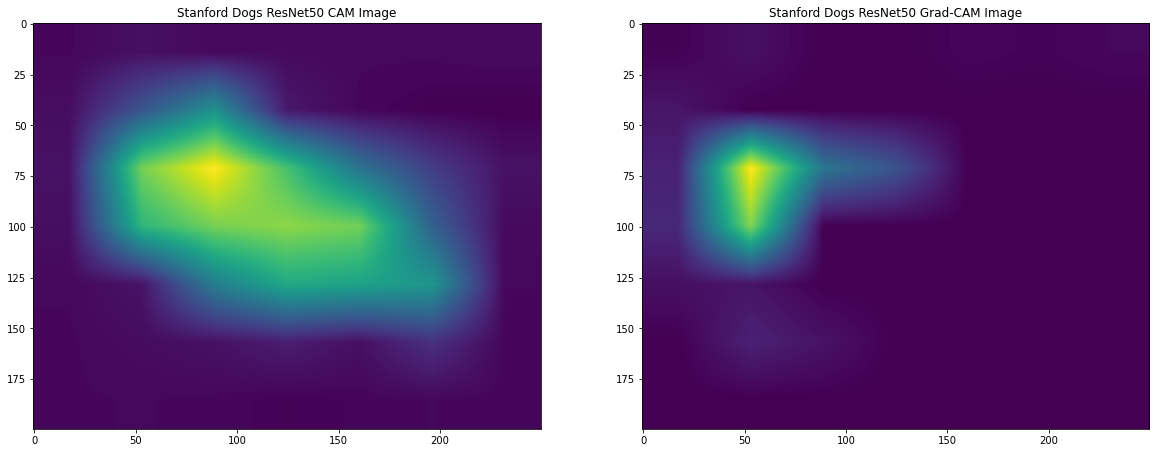

In [37]:
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('Stanford Dogs ResNet50 CAM Image')
plt.imshow(cam_image)

plt.subplot(1, 2, 2)
plt.title('Stanford Dogs ResNet50 Grad-CAM Image')
plt.imshow(grad_cam_image)

## 7.2 CAM, Grad-CAM 원본 합성 결과 비교

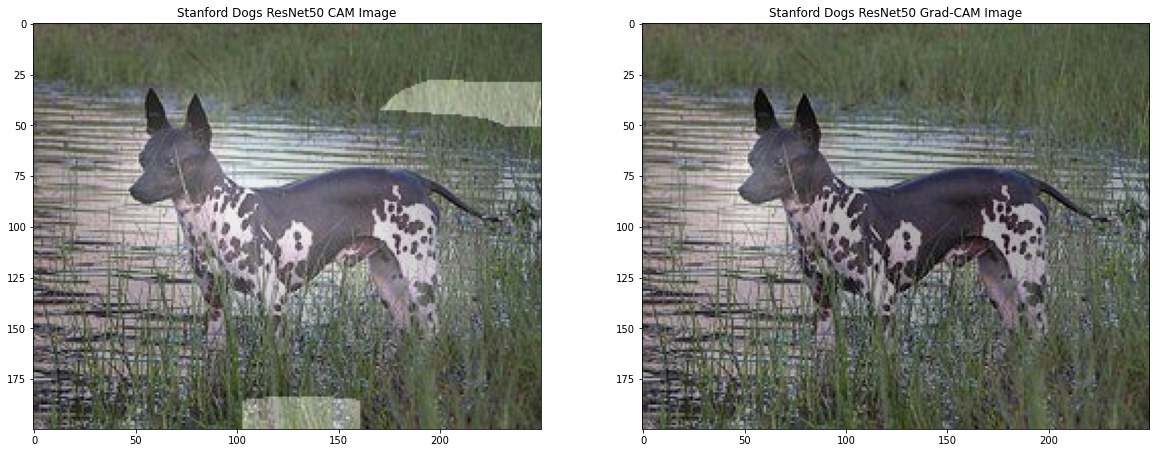

In [38]:
origin_image = item['image'].astype(np.uint8)

cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
cam_blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)

grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('Stanford Dogs ResNet50 CAM Image')
plt.imshow(cam_blended_image)

plt.subplot(1, 2, 2)
plt.title('Stanford Dogs ResNet50 Grad-CAM Image')
plt.imshow(grad_blended_image)

## 7.3 CAM, Grad-CAM 바운딩 박스 비교

In [39]:
cam_rect = get_bbox(cam_image)
cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [cam_rect], 0, (0, 0, 255), 2)

grad_cam_rect = get_bbox(grad_cam_image)
grad_cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [grad_cam_rect], 0, (0, 0, 255), 2)

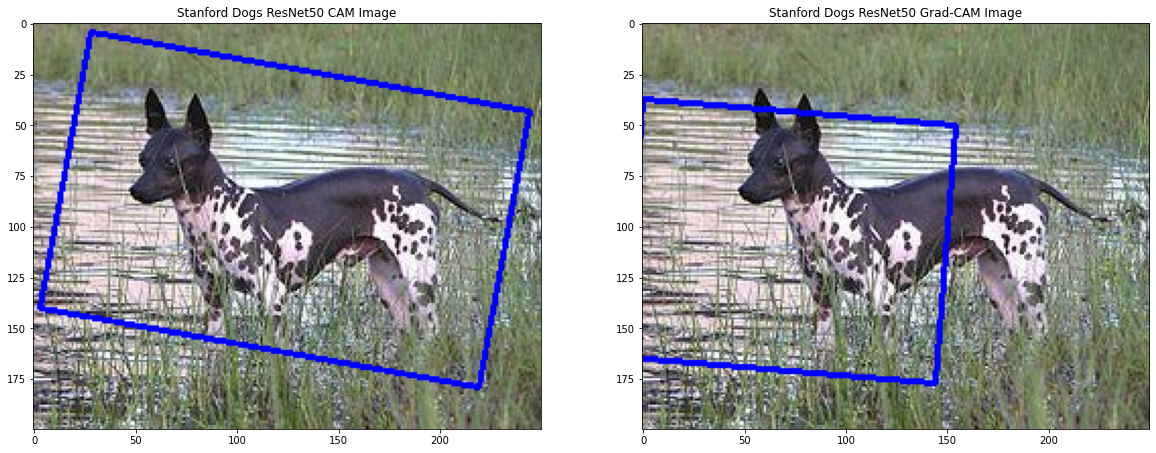

In [40]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('Stanford Dogs ResNet50 CAM Image')
plt.imshow(cam_bbox_image)

plt.subplot(1, 2, 2)
plt.title('Stanford Dogs ResNet50 Grad-CAM Image')
plt.imshow(grad_cam_bbox_image)

## 7.4 CAM, Grad-CAM IoU 비교

In [41]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
cam_iou = get_iou(cam_pred_bbox, item['objects']['bbox'][0])

grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])
grad_cam_iou = get_iou(grad_cam_pred_bbox, item['objects']['bbox'][0])

In [42]:
print(f'CAM IoU : {cam_iou}')
print(f'Grad-CAM IoU : {grad_cam_iou}')

CAM IoU : 0.5510610522217629
Grad-CAM IoU : 0.39314900125939145


# 8. 최종 bounding box

In [43]:
y1 = int(item['image'].shape[0] * item['objects']['bbox'][0][0])
y2 = int(item['image'].shape[0] * item['objects']['bbox'][0][2])
x1 = int(item['image'].shape[1] * item['objects']['bbox'][0][1])
x2 = int(item['image'].shape[1] * item['objects']['bbox'][0][3])
orig_rect = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])

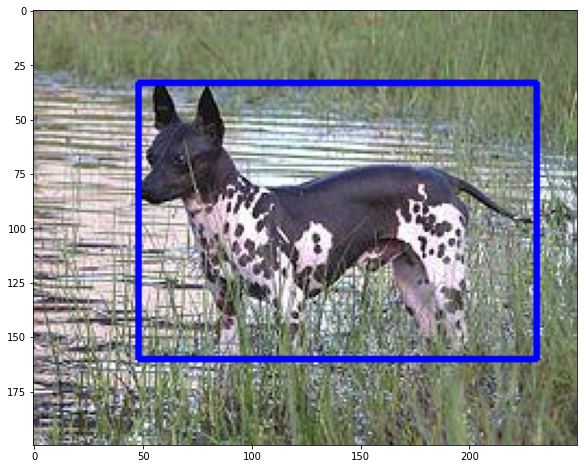

In [44]:
origin_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [orig_rect], 0, (0, 0, 255), 2)

plt.figure(figsize=(20, 8))
plt.imshow(origin_bbox_image)

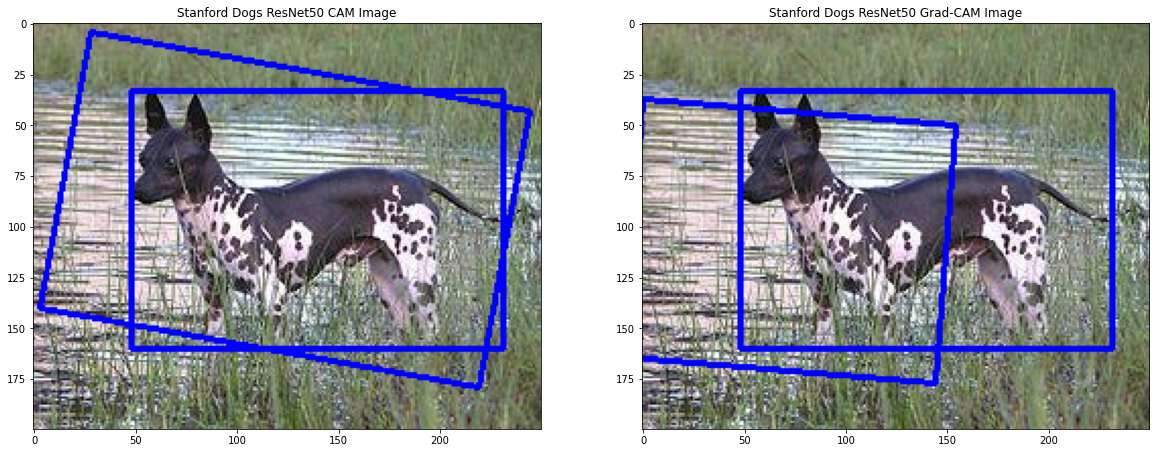

In [45]:
cam_bbox_image = cv2.drawContours(cam_bbox_image, [orig_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_image = cv2.drawContours(grad_cam_bbox_image, [orig_rect], 0, (0, 0, 255), 2)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('Stanford Dogs ResNet50 CAM Image')
plt.imshow(cam_bbox_image)

plt.subplot(1, 2, 2)
plt.title('Stanford Dogs ResNet50 Grad-CAM Image')
plt.imshow(grad_cam_bbox_image)

# 회고

- xai에 대한 이해를 할 수 있었다.
- 좀더 좋은 성능을 내지 못해서 아쉽다.
- bounding box가 왜 두 개가 나왔는지 연구가 필요하다

# 출처

https://github.com/museonghwang/AIFFEL/blob/master/GoingDeeper_06/%5BGD-06%5D%20Create%20Class%20Activation%20Map%20And%20Evaluation.ipynb